<img src="https://images.theconversation.com/files/288176/original/file-20190815-136190-cn8sg3.jpg?ixlib=rb-1.1.0&rect=0%2C793%2C5515%2C2753&q=45&auto=format&w=1356&h=668&fit=crop">

<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Inter:wght@500&display=swap" rel="stylesheet">


<h1 style="font-size: 30px; font-family: 'Inter', sans-serif;">Introducing to the Plant Disease Recognition Dataset</h1>
<p style="font-size: 17px; font-family: 'Inter', sans-serif;">This dataset contains three labels: <b>Healthy</b>, <b>Powdery</b>, <b>Rust</b> referring to plant conditions. There is a total of 1530 images divided into train, test, and validation sets.</p>

<h3 style="font-size: 25px; font-family: 'Inter', sans-serif;">Rusts</h3>
<p style="font-size: 17px; font-family: 'Inter', sans-serif;">
    
Rusts are plant diseases caused by pathogenic fungi of the order Pucciniales (previously known as Uredinales).

An estimated 168 rust genera and approximately 7,000 species, more than half of which belong to the genus Puccinia, are currently accepted.[1] Rust fungi are highly specialized plant pathogens with several unique features. Taken as a group, rust fungi are diverse and affect many kinds of plants. However, each species has a very narrow range of hosts and cannot be transmitted to non-host plants. In addition, most rust fungi cannot be grown easily in pure culture.

A single species of rust fungi may be able to infect two different plant hosts in different stages of its life cycle, and may produce up to five morphologically and cytologically distinct spore-producing structures viz., spermogonia, aecia, uredinia, telia, and basidia in successive stages of reproduction.[2] Each spore type is very host specific, and can typically infect only one kind of plant.

Rust fungi are obligate plant pathogens that only infect living plants. Infections begin when a spore lands on the plant surface, germinates, and invades its host. Infection is limited to plant parts such as leaves, petioles, tender shoots, stem, fruits, etc. Plants with severe rust infection may appear stunted, chlorotic (yellowed), or may display signs of infection such as rust fruiting bodies. Rust fungi grow intracellularly, and make spore-producing fruiting bodies within or, more often, on the surfaces of affected plant parts. Some rust species form perennial systemic infections that may cause plant deformities such as growth retardation, witch's broom, stem canker, galls, or hypertrophy of affected plant parts.

Rusts get their name because they are most commonly observed as deposits of powdery rust-coloured or brown spores on plant surfaces. The Roman agricultural festival Robigalia (April 25) has ancient origins in combating wheat rust.</p>

<img src="https://www.gardeningknowhow.com/wp-content/uploads/2020/11/plant-rust-disease.jpg" width="500px" height="300px">


<h3 style="font-size: 25px; font-family: 'Inter', sans-serif;">Powdery</h3>

<p style="font-size: 17px; font-family: 'Inter', sans-serif;">

Powdery mildew is a fungal disease that affects a wide range of plants. Powdery mildew diseases are caused by many different species of fungi in the order Erysiphales. Powdery mildew is one of the easier plant diseases to identify, as its symptoms are quite distinctive. Infected plants display white powdery spots on the leaves and stems. The lower leaves are the most affected, but the mildew can appear on any above-ground part of the plant. As the disease progresses, the spots get larger and denser as large numbers of asexual spores are formed, and the mildew may spread up and down the length of the plant.

Powdery mildew grows well in environments with high humidity and moderate temperatures. Greenhouses provide an ideal moist, temperate environment for the spread of the disease. This causes harm to agricultural and horticultural practices where powdery mildew may thrive in a greenhouse setting. In an agricultural or horticultural setting, the pathogen can be controlled using chemical methods, bio organic methods, and genetic resistance. It is important to be aware of powdery mildew and its management as the resulting disease can significantly reduce important crop yields.
</p>

<img src="https://media.istockphoto.com/photos/grapevine-diseases-downy-mildew-is-a-fungal-disease-that-affects-a-picture-id1161364148?k=6&m=1161364148&s=612x612&w=0&h=BzE8nsZHyGD3y7r1wvKIYDrvqLQcJdk_efFCUNB3134=" width="500px" height="300px">

# Import requirements

In [1]:
!pip install -q addict

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import os
import random
from addict import Dict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# Functions

In [3]:
def seed_everything(seed:int=42) -> None:
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def get_optimizer(model:torch.nn.Module, name:str="SGD", parameters:dict={}) -> torch.optim.Optimizer:
    optimizers = {
        "SGD": torch.optim.SGD,
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "RMSprop": torch.optim.RMSprop,
    }
    
    instance = optimizers.get(name, "SGD")     
    optimizer = instance(model.parameters(), **parameters)
    
    return optimizer


def get_scheduler(optimizer:torch.optim.Optimizer, name:str, parameters:dict):
    schedulers = {
        "ReduceLROnPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "LambdaLR": torch.optim.lr_scheduler.LambdaLR,
        "StepLR": torch.optim.lr_scheduler.StepLR,
        "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR,
        "MultiplicativeLR": torch.optim.lr_scheduler.MultiplicativeLR,
        "MultiStepLR": torch.optim.lr_scheduler.MultiStepLR,
    }
    
    instance = schedulers[name]     
    scheduler = instance(optimizer, **parameters)
    
    return scheduler



def accuracy_score(predictions:torch.Tensor, targets:torch.Tensor) -> torch.Tensor:
    amount = (predictions == targets).sum()
    accuracy = amount / targets.size(0)
    
    return accuracy



def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)
        
def plot_images(rows, cols, indexes, class_=0):
    min_index = min(indexes)
    max_index = max(indexes)
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i in range(*indexes):
        item = train_dataset[i]
        image = item.image
        label = item.label

        if label == class_:
            ax = fig.add_subplot(rows, cols, (i - min_index)+1)
            ax.imshow(image.permute(1, 2, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

    fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
    fig.show()
    
    
def get_logger(name:str=__name__, format:str="[%(asctime)s][%(levelname)s]: %(message)s") -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(format)

    file_handler = logging.FileHandler(name)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    stream_handler.setFormatter(formatter)

    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    logger.propagate = False
    
    return logger

# Configs

In [16]:
config = Dict({
    "train_path": "D:/pbl/archive/Train/Train",
    "test_path": "D:/pbl/code/archive/Test/Test",
    "validation_path": "D:/pbl/archive/Validation/Validation"
})

train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 5,
    "seed": 2021,
    "image_shape": (128, 128),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32, 

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },
    
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


seed_everything(train_config.seed)

# Dataset

In [17]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, path, augmentations=None, image_shape=(256, 256), channels="RGB"):
        self.__images_labels = []
        self.image_shape = image_shape
        self.channels = channels
        self.augmentations = augmentations
        
        if os.path.exists(path):
            self.labels = os.listdir(path)
            for label in self.labels:
                label_path = os.path.join(path, label)
                if os.path.isdir(label_path):
                    files = os.listdir(label_path)
                    for file in files:
                        if file.endswith("jpg") or file.endswith("png"):
                            image_path = os.path.join(label_path, file)
                            self.__images_labels.append((image_path, label))
                        else:
                            pass
                else:
                    pass
                
        else:
            pass
        
    def _load(self, path, channels="RGB"):
        width, height = self.image_shape
        loader = A.Compose([
            A.Resize(width=width, height=height),
            ToTensorV2(),
        ])
        
        image_array = np.array(Image.open(path).convert(channels))
        return loader(image=image_array)["image"]
    
    def __len__(self):
        return len(self.__images_labels)
    
    def __getitem__(self, index):
        path, label = self.__images_labels[index]
        image = self._load(path)
        
        if self.augmentations is not None:
            image = image.permute(1, 2, 0).numpy()
            image = self.augmentations(image=image)["image"]
            
        label = self.labels.index(label)
        
        return Dict({
            "image": image,
            "label": label,
        })
    
    
def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label
        
        all_images.append(item.image.tolist())
        all_labels.append(label)
        
    return { 
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.int8)
    }
        

# Exploratory Data Analysis

In [18]:
train_dataset = PlantDiseaseDataset(path=config.train_path, 
                                    image_shape=train_config.image_shape, 
                                    channels=train_config.image_channels)

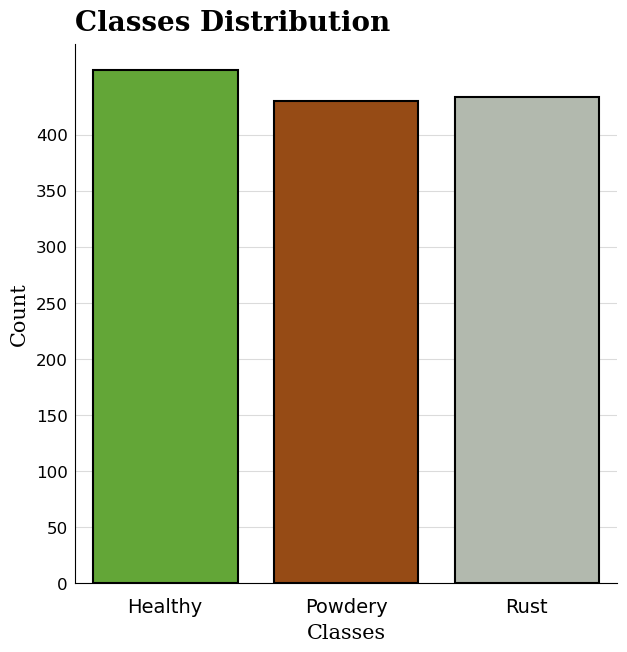

In [19]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Extract labels (assuming directories represent class names)
labels = os.listdir(config.train_path)  # Update this if your structure differs

# Compute paths and file counts
label_pathes = [os.path.join(config.train_path, label) for label in labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

# Plot
palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.barplot(x=labels, y=amount, palette=palette, ec="#000", linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 450, 50)))
ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("Count", fontsize=15, fontfamily="serif", labelpad=5)

# Function to hide spines (if defined elsewhere)
def hide_spines(ax):
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

hide_spines(ax)
plt.show()


C:\Users\shruti thorat\AppData\Local\Temp\ipykernel_28648\771572624.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


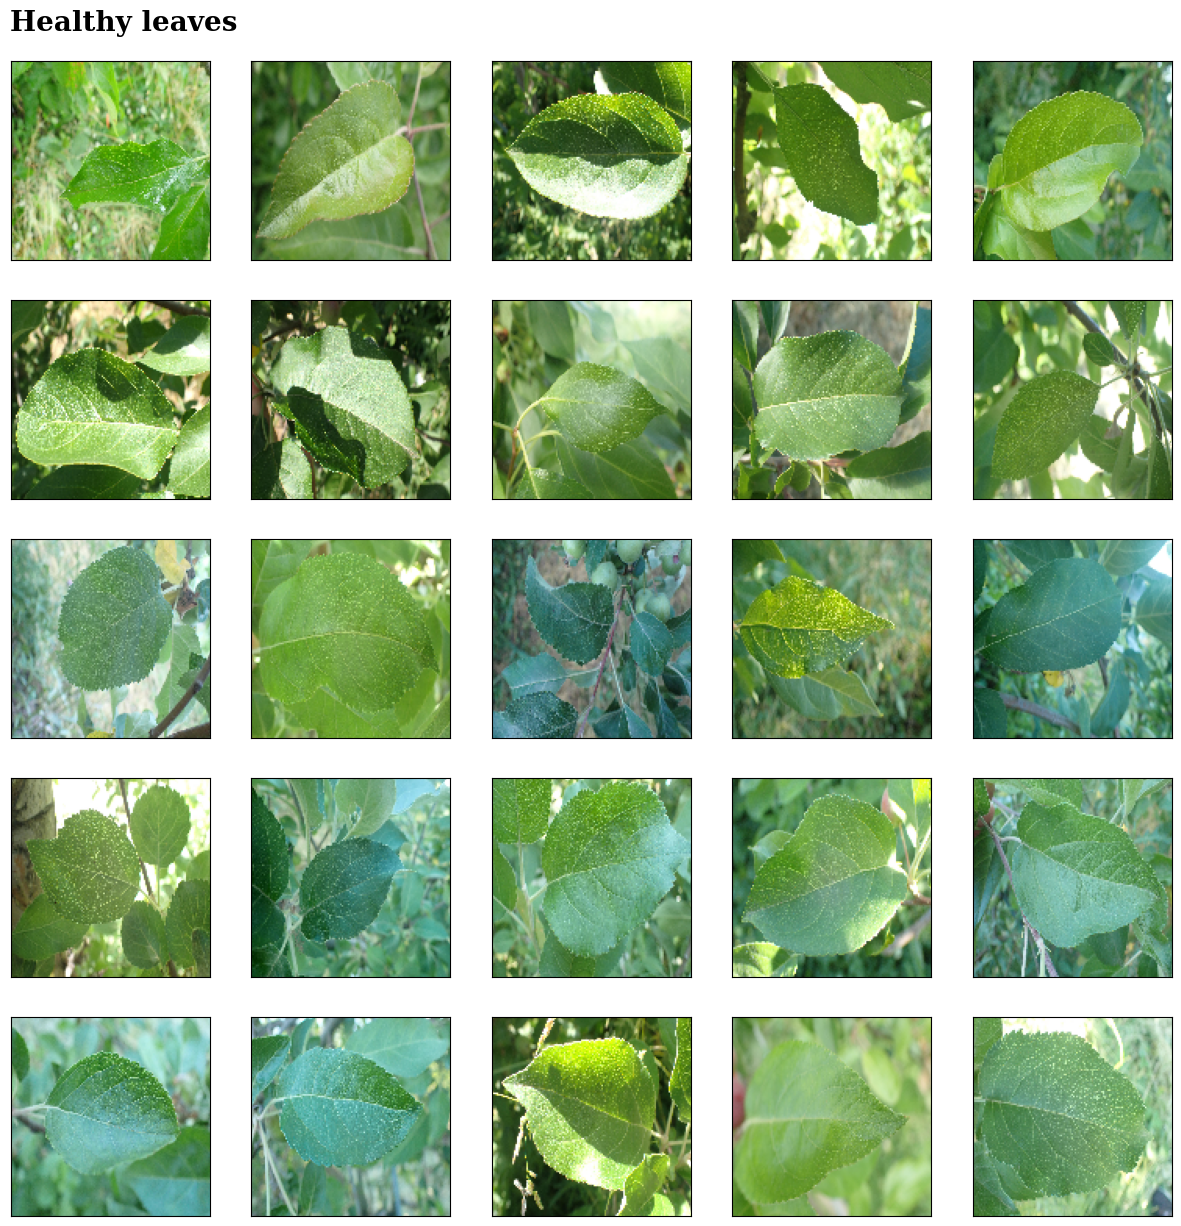

In [20]:
plot_images(rows=5, cols=5, indexes=(0, 25), class_=0)

C:\Users\shruti thorat\AppData\Local\Temp\ipykernel_28648\771572624.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


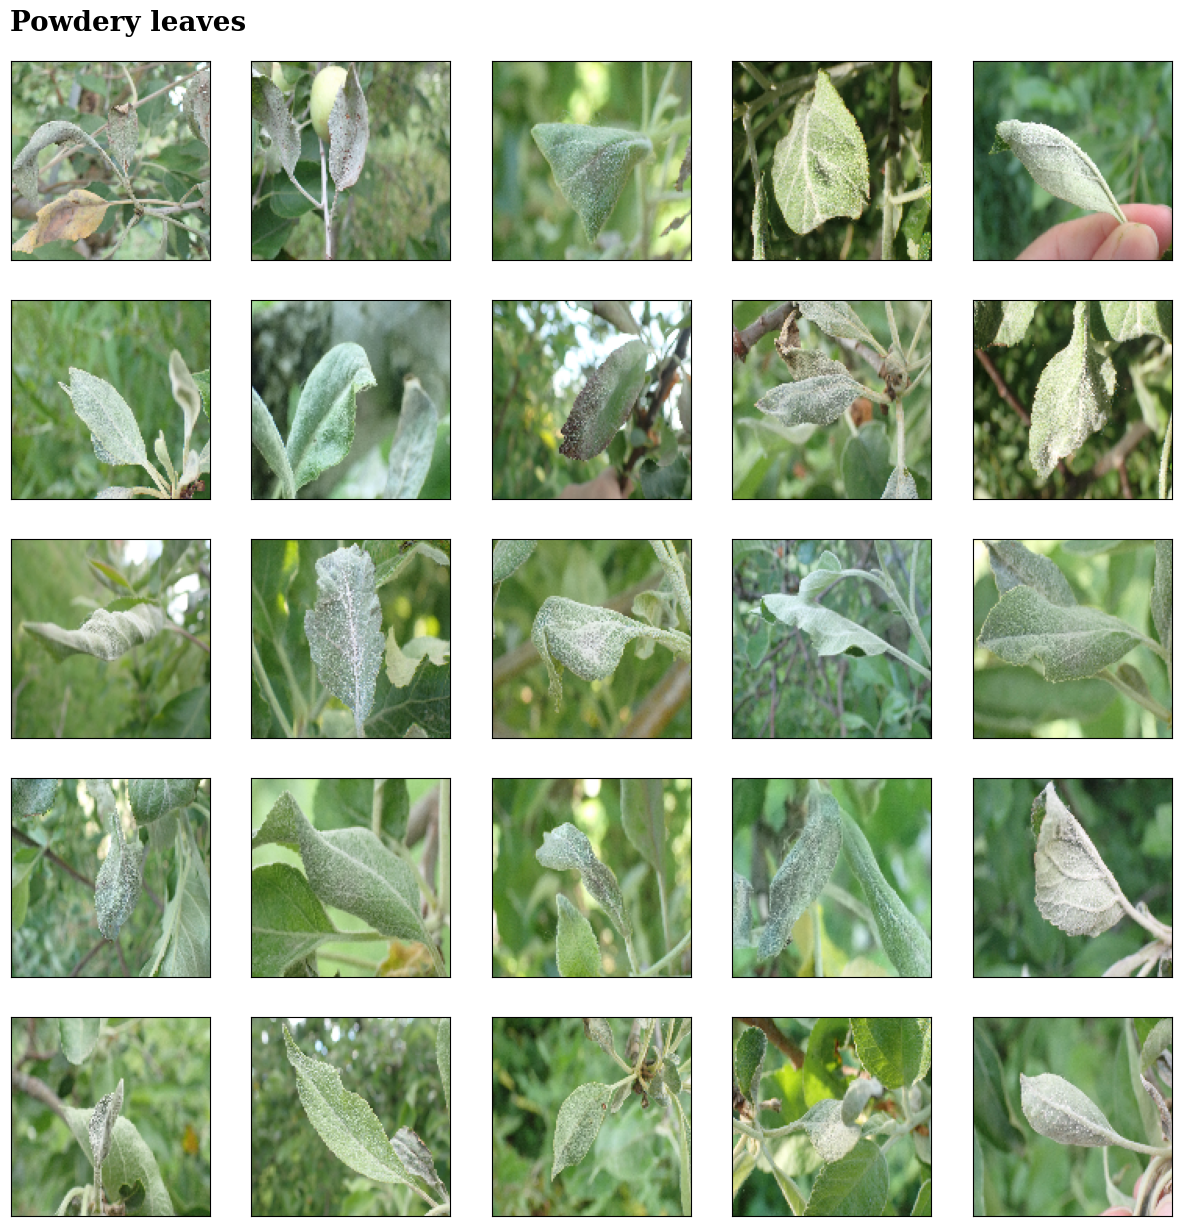

In [21]:
plot_images(rows=5, cols=5, indexes=(500, 525), class_=1)

C:\Users\shruti thorat\AppData\Local\Temp\ipykernel_28648\771572624.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


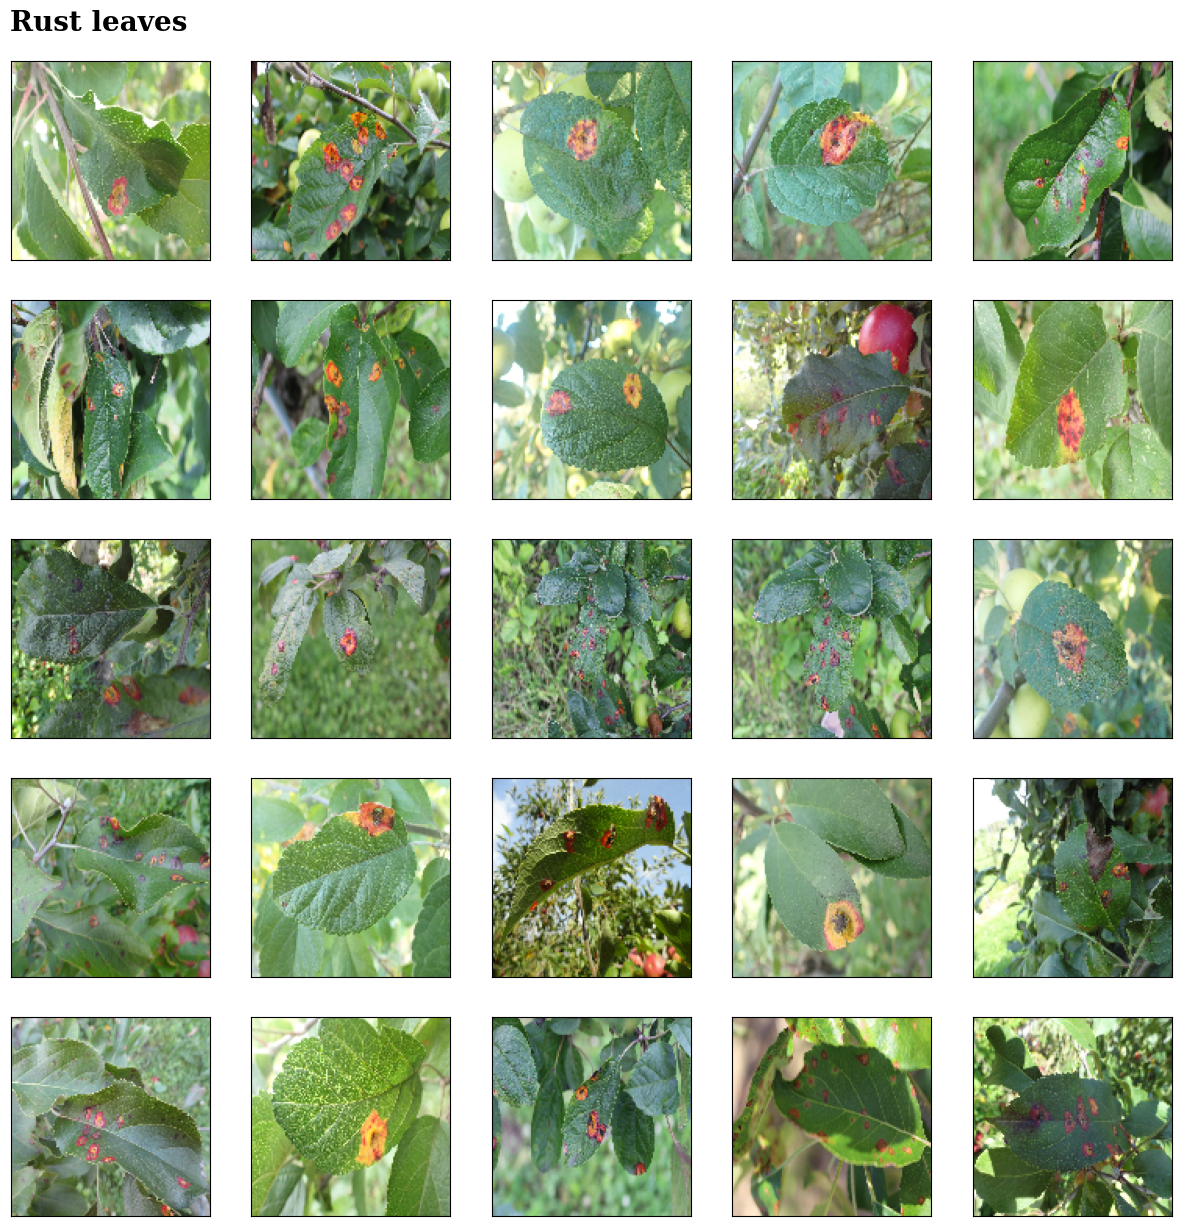

In [22]:
plot_images(rows=5, cols=5, indexes=(len(train_dataset)-25, len(train_dataset)), class_=2)

# Preprate the Datasets & Data Loaders

In [25]:
train_dataset = PlantDiseaseDataset(path=config.train_path, 
                                    augmentations=train_config.augmentations,
                                    image_shape=train_config.image_shape, 
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path, 
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape, 
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path, 
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape, 
                                   channels=train_config.image_channels)

In [26]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=train_config.batch_size, 
                          num_workers=train_config.num_workers, 
                          pin_memory=True, 
                          shuffle=True, 
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset, 
                               batch_size=train_config.batch_size*2, 
                               num_workers=train_config.num_workers, 
                               pin_memory=True, 
                               shuffle=False, 
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=train_config.batch_size*2, 
                         num_workers=train_config.num_workers, 
                         pin_memory=True, 
                         shuffle=False, 
                         collate_fn=collate_fn)

# Modelling

In [27]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes=2):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.resnet34(pretrained=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [28]:
class Trainer:
    def __init__(self, model, criterion, optimizer,  metric, scheduler=None, logger=None, device="cpu"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.logger = logger
        self.device = torch.device(device)
        self.best_validation_loss = 0
        self.metric = metric
        self.history = Dict({})
        
    def __log(self, logs):
        for k, v in logs.items():
            if k not in self.history:
                self.history[k] = []
                
            self.history[k].append(v)
            
    def evaluate(self, loader):
        loss, score, length = 0, 0, len(loader)
            
        self.model.to(self.device)
        with torch.no_grad():
            loop = tqdm(loader, position=0, colour="BLACK", desc=f"Evaluating: ", leave=True)
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.model.eval()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                loss += batch_loss.item()
                
                batch_score = self.metric(predictions, labels).item()
                score += batch_score

            loss /= length
            score /= length
        
        return loss, score
        


    def fit(self, train_loader, validation_loader=None, epochs=10):
        self.model.to(self.device)
        train_length = len(train_loader)
        
        for epoch in range(epochs): 
            epoch_loss, epoch_score = 0, 0
            
            loop = tqdm(train_loader, position=0, colour="BLACK", leave=True, desc=f"Epoch [{epoch+1}/{epochs}]: ")
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                self.model.train()
                
                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()
                
                batch_loss = self.criterion(probabilities, labels)
                epoch_loss += batch_loss.item()
                
                batch_score = self.metric(predictions, labels).item()
                epoch_score += batch_score
                
                batch_loss.backward()
                self.optimizer.step()
                
            epoch_loss /= train_length
            epoch_score /= train_length
            
            self.__log({"train_losses": epoch_loss, "train_scores": epoch_score})
            if self.logger is not None: self.logger.info(f"Epoch [{epoch+1}/{epochs}]: Loss: {epoch_loss} | Metric: {epoch_score}")
                
            if validation_loader is not None:
                validation_loss, validation_score = self.evaluate(validation_loader)
                self.__log({"validation_losses": validation_loss, "validation_scores": validation_score})
                if self.logger is not None: self.logger.info(f"Validation Epoch [{epoch+1}/{epochs}]: Loss: {validation_loss} | Metric: {validation_score}")
            


                if self.scheduler is not None:
                    if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(validation_loss)
                    else:
                        self.scheduler.step()

                    if self.logger is not None:
                        lr = self.optimizer.param_groups[0]["lr"]
                        self.logger.info(f"Epoch [{epoch+1}/{epochs}] Learning Rate: {lr}")

In [29]:
model = PlantDiseaseModel(classes=len(train_dataset.labels))
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model=model, 
                          name=train_config.optimizer.type, 
                          parameters=train_config.optimizer.parameters)

if "scheduler" in train_config:
    scheduler = get_scheduler(optimizer=optimizer, 
                              name=train_config.scheduler.type, 
                              parameters=train_config.scheduler.parameters)
    
trainer_logger = get_logger("trainer")
trainer = Trainer(model=model, 
                  criterion=criterion,
                  metric=accuracy_score,
                  optimizer=optimizer, 
                  scheduler=scheduler,
                  logger=trainer_logger,
                  device=train_config.device)

C:\Users\shruti thorat\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shruti thorat\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
trainer.fit(train_loader=train_loader, 
            validation_loader=validation_loader, 
            epochs=train_config.epochs)

Epoch [1/5]: 100%|██████████| 42/42 [05:37<00:00,  8.04s/it]
[2024-11-21 12:00:16,696][INFO]: Epoch [1/5]: Loss: 0.6695291357381004 | Metric: 0.8772321428571429
Evaluating: 100%|██████████| 1/1 [00:13<00:00, 13.14s/it]
[2024-11-21 12:00:29,867][INFO]: Validation Epoch [1/5]: Loss: 0.7012673020362854 | Metric: 0.8500000238418579
[2024-11-21 12:00:29,867][INFO]: Epoch [1/5] Learning Rate: 0.001
Epoch [2/5]: 100%|██████████| 42/42 [04:40<00:00,  6.68s/it]
[2024-11-21 12:05:10,270][INFO]: Epoch [2/5]: Loss: 0.6236422061920166 | Metric: 0.9263392857142857
Evaluating: 100%|██████████| 1/1 [00:09<00:00,  9.94s/it]
[2024-11-21 12:05:20,206][INFO]: Validation Epoch [2/5]: Loss: 0.6571575403213501 | Metric: 0.8999999761581421
[2024-11-21 12:05:20,206][INFO]: Epoch [2/5] Learning Rate: 0.001
Epoch [3/5]: 100%|██████████| 42/42 [04:43<00:00,  6.76s/it]
[2024-11-21 12:10:03,967][INFO]: Epoch [3/5]: Loss: 0.6780060260068803 | Metric: 0.8703869041942415
Evaluating: 100%|██████████| 1/1 [00:11<00:00, 

C:\Users\shruti thorat\AppData\Local\Temp\ipykernel_28648\3275710503.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


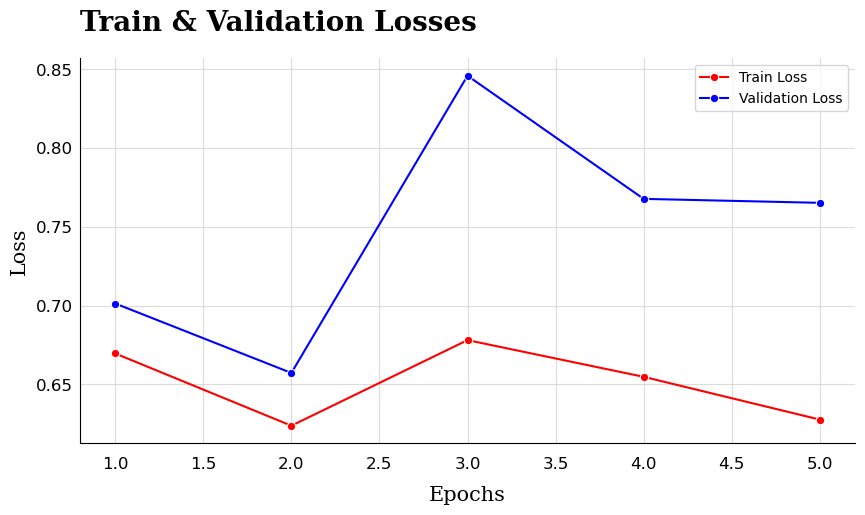

In [31]:
epochs_ = range(1, train_config.epochs+1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=trainer.history.train_losses, color="red", marker="o", label="Train Loss", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=trainer.history.validation_losses, color="blue", marker="o", label="Validation Loss", zorder=2, ax=ax)
ax.set_title("Train & Validation Losses", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
hide_spines(ax)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Loss", fontsize=15, fontfamily="serif", labelpad=5)
ax.legend()
fig.show()

C:\Users\shruti thorat\AppData\Local\Temp\ipykernel_28648\1485051734.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


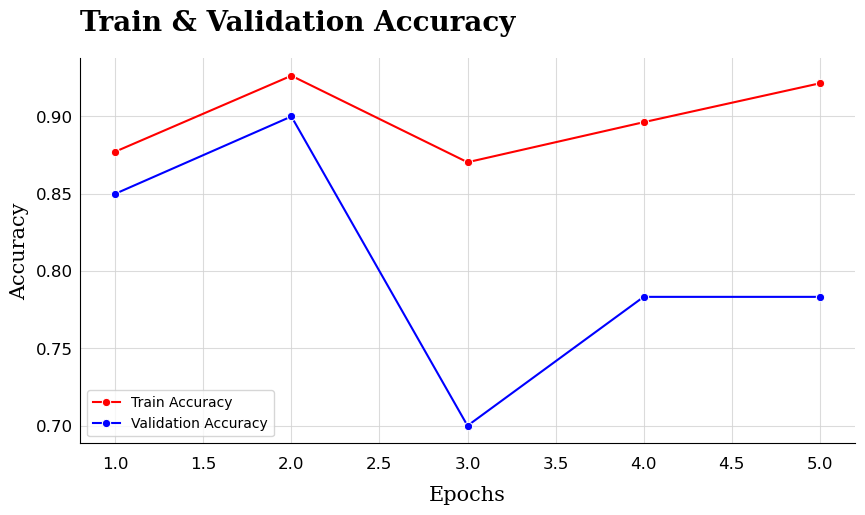

In [32]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=trainer.history.train_scores, color="red", marker="o", label="Train Accuracy", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=trainer.history.validation_scores, color="blue", marker="o", label="Validation Accuracy", zorder=2, ax=ax)
ax.set_title("Train & Validation Accuracy", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
hide_spines(ax)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Accuracy", fontsize=15, fontfamily="serif", labelpad=5)
ax.legend()
fig.show()

<h1 style="font-size: 30px; font-family: 'Inter', sans-serif;">References</h1>
<ul style="font-size: 15px; font-family: 'Inter', sans-serif;">
<li><a href="https://arxiv.org/abs/1512.03385">Resnet50 - https://arxiv.org/abs/1512.03385</a>
<li><a href="https://arxiv.org/abs/1711.05101">Adam - https://arxiv.org/abs/1512.03385</a>
<li><a href="https://machinelearningmastery.com/cross-entropy-for-machine-learning/">Cross Entropy Loss - https://machinelearningmastery.com/cross-entropy-for-machine-learning/</a>
</ul>

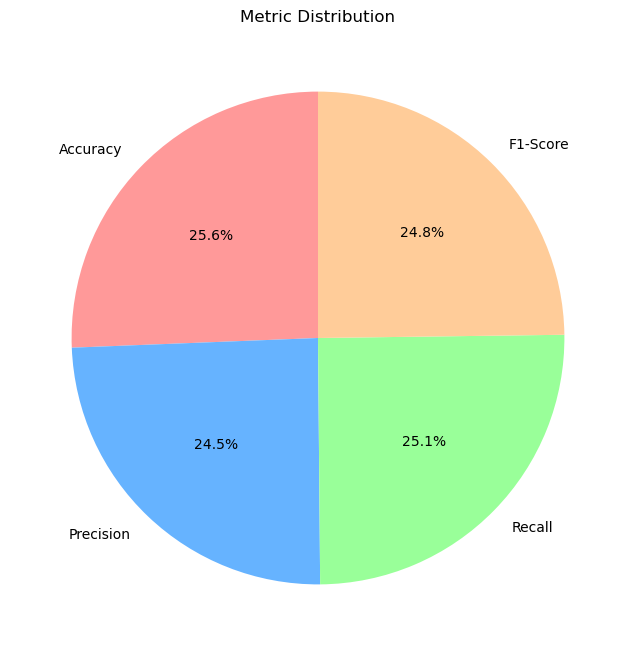

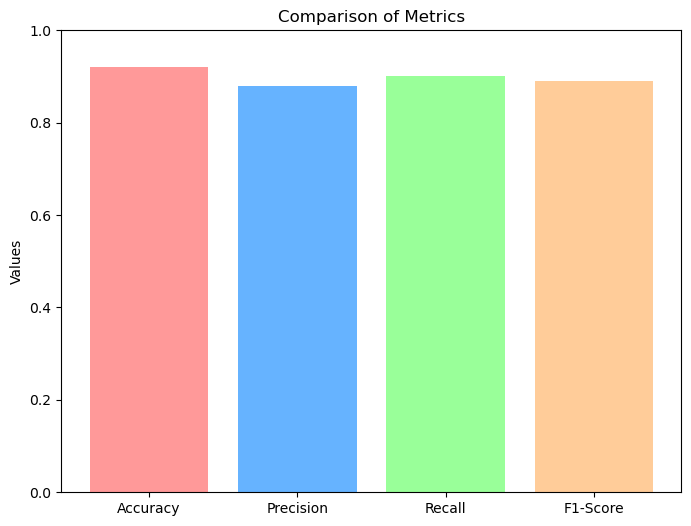

In [1]:
import matplotlib.pyplot as plt

# Sample metric values (placeholders; replace with actual values if available)
metrics = {
    "Accuracy": 0.92,
    "Precision": 0.88,
    "Recall": 0.90,
    "F1-Score": 0.89
}

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(metrics.values(), labels=metrics.keys(), autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Metric Distribution')
plt.show()

# Bar graph
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.ylim(0, 1)
plt.ylabel('Values')
plt.title('Comparison of Metrics')
plt.show()


In [2]:
!pip install tensorflow numpy pandas scikit-learn opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


FileUpload(value={}, accept='image/*', description='Upload')

File uploaded: disease1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


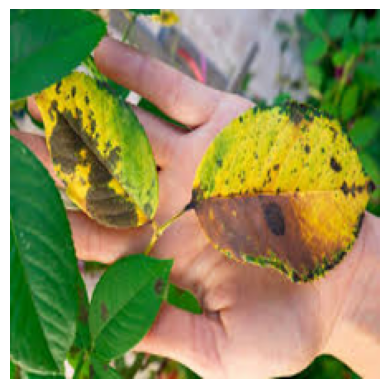

Top predictions:
1. buckeye (12.36%)
2. sulphur_butterfly (12.09%)
3. head_cabbage (8.54%)

Care information for the predicted plant is not available.


In [2]:
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import io

# Load pre-trained MobileNetV2 model
model = MobileNetV2(weights='imagenet')

# Plant care information (example dictionary)
plant_care_info = {
    'daisy': {'sunlight': 'Full sun', 'water': 'Moderate'},
    'sunflower': {'sunlight': 'Full sun', 'water': 'Regular, moderate'},
    'hibiscus': {'sunlight': 'Partial to full sun', 'water': 'Frequent'},
    'rose': {'sunlight': 'Full sun', 'water': 'Regular, moist soil'},
    'cactus': {'sunlight': 'Full sun', 'water': 'Low'},
    'palm': {'sunlight': 'Bright indirect light', 'water': 'Moderate, moist soil'},
}

# Function to handle uploaded images and plant classification
def plant_image_detector(image_data):
    # Open the image from the uploaded data
    img = Image.open(io.BytesIO(image_data))

    # Resize and preprocess the image
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)[0]

    # Display the uploaded image
    img_display = np.array(img)
    plt.imshow(img_display)
    plt.axis('off')  # Hide axes
    plt.show()

    # Print predictions and check care information
    print("Top predictions:")
    plant_class = None
    for i, pred in enumerate(decoded_predictions):
        print(f"{i+1}. {pred[1]} ({pred[2]*100:.2f}%)")
        if pred[1].lower() in plant_care_info:  # Check if plant type is in our care dictionary
            plant_class = pred[1].lower()

    # Provide plant care information
    if plant_class:
        care_info = plant_care_info[plant_class]
        print(f"\nPlant classified as: {plant_class.capitalize()}")
        print(f"Sunlight requirement: {care_info['sunlight']}")
        print(f"Water requirement: {care_info['water']}")
    else:
        print("\nCare information for the predicted plant is not available.")

# Function to handle file upload
def on_upload_change(change):
    # Get the uploaded file data
    for filename, file_info in change['new'].items():
        print(f"File uploaded: {filename}")
        plant_image_detector(file_info['content'])

# Create the file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Set the callback function to be called when a file is uploaded
upload_widget.observe(on_upload_change, names='value')

# Display the widget
display(upload_widget)
